# Introduction

THis is the 


# Input data

### Abbreviations

dsgn - New Design

bank - Material Bank (collection of preowned, available elements)

LCA - Life Cycle Assessment - Global Warming Potential (GWP) expressed in kilograms of CO2 equivalent of all the emited green-house gases (kgCO2e). 

### Input assumptions

In [55]:
NEW_PRICE = 8000    # NOK/m3, based on average from https://www.byggmax.no/catalogsearch/result/?q=KONSTRUKSJONSVIRKE
NEW_LCA_GWP_A1_A3 = 28.9 # kgCO2e/m3, assuming 'fossil GWP' and 16% moisture, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
NEW_LCA_GWP_A5 = 1.59   # kgCO2e/m3, assuming 'fossil GWP' and 16% moisture, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
NEW_DISTANCE = 100  # km, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html

DENSITY = 491                 # kg/m3, assuming 16% moisture, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
TRANSPORT_LCA_GWP = 0.0318    # kgCO2e/km, assuming 45% (90% and 0% back) utilisation of 34t truck, burning 0.027 l/tonkm (both ways), based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
# TRANSPORT_PRICE = ???       # nok/tonkm, ?

MIN_LENGTH = 1.0    # m
MAX_LENGTH = 12.0   # m
MIN_AREA = 0.0025   # m2, 5x5cm
MAX_AREA = 0.125    # m2, 25x50cm

DSGN_COUNT = 5
BANK_COUNT = 100

BANK_MAX_DISTANCE = 500   # km
BANK_LCA_GWP_A1_A3 = NEW_LCA_GWP_A1_A3 * 0.0778     # kgCO2e/m3, based on new product and factor derived from (Eberhardt, 2020)
BANK_LCA_GWP_A5 = NEW_LCA_GWP_A5                    # kgCO2e/m3, assuming it is the same as for new product
BANK_PRICE = 4000         # NOK/m3, based on Ormondroyd et al. (2016), where used beam 9"x1.5"x16ft costs 14gbp, so approximately 168 NOK, so a cubic meter appr. 4020nok. TODO: better analysis would be valuable.

\* TODO we need to explain in paper which allocation method for LCA we select. Well described in (Eberhardt, 2020). I assumed for now the most common cut-off, and that we are at the second cycle (even though in Oslo it will be third). I just multiplied the new LCA for EPD product and multiplied by 7/90=0.0778. It is not the correct simplification!

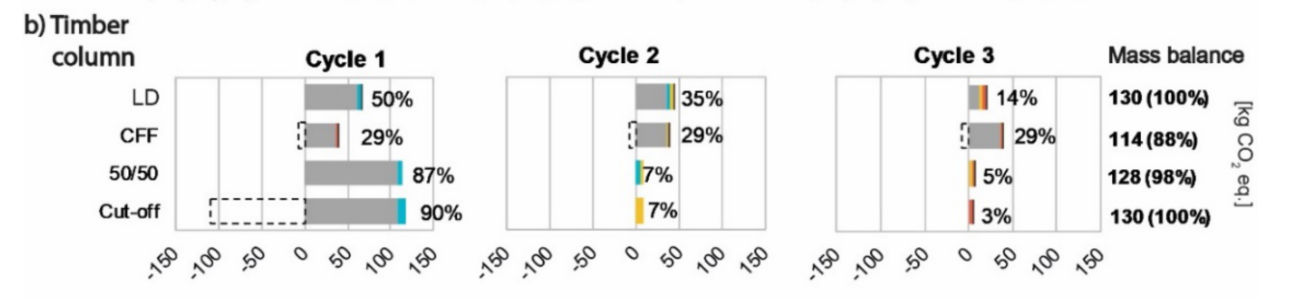

\* TODO other EPDs have other numbers, for example Limtre has 760km distance, 33kg for A1-A3 and 3.2kg for A5: https://www.epd-norge.no/heltreprodukter/limtre-article3247-320.html 

\* TODO we should consult the fossil vs bio approach to GWP calculation with LCA expert. In that EPD the difference is 28.9 vs -741 (2600% better)

\* TODO we should consider implementing more parameters than just GWP:
*  ODP Depletion potential of the stratospheric ozone layer;
*  POCP Formation potential of tropospheric photochemical oxidants;
*  AP Acidification potential of land and water;
*  EP Eutrophication potential;
*  ADPM Abiotic depletion potential for non fossil resources;
*  ADPE Abiotic depletion potential for fossil resources


### Generate pseudorandom numbers
For the material bank:

In [61]:
import pandas as pd
import random

random.seed(3)

bank = pd.DataFrame()
bank['Length'] = [x/10 for x in random.choices(range(int(MIN_LENGTH*10), int(MAX_LENGTH*10)), k=BANK_COUNT)]        # [m], random between the range
bank['Area'] = bank.apply(lambda row: random.choice(range(0, int(MAX_AREA*10000)-int(MIN_AREA*10000))) /10000 /MAX_LENGTH * row['Length'] + MIN_AREA, axis=1)        # [m2], random between the range but dependent on the length of the element
bank['Distance'] = random.choices(range(0, BANK_MAX_DISTANCE), k=BANK_COUNT)                                      # [km], random between 1 and 500 km
bank['Price'] = bank.apply(lambda row: row['Length'] * row['Area'] * BANK_PRICE, axis=1)                          # [NOK], length * area * price (per m3)
bank['LCA_GWP'] = bank.apply(lambda row: row['Length'] * row['Area'] * (BANK_LCA_GWP_A1_A3 + BANK_LCA_GWP_A5)+ row['Distance'] * TRANSPORT_LCA_GWP, axis=1)    # [kgCO2e], length * area * processing_emissions + distance * transport_emissions  
bank['Weight'] = bank.apply(lambda row: row['Length'] * row['Area'] * DENSITY, axis=1)    # [kg], length * area * density

In [62]:
bank

,Length,Area,Distance,Price,LCA_GWP,Weight
0,3.6,0.039070,77,562.608000,2.988481,69.060132
1,6.9,0.068338,2,1886.115000,1.873525,231.520616
2,5.0,0.011250,471,225.000000,15.193711,27.618750
3,7.6,0.068240,439,2074.496000,15.950897,254.644384
4,7.8,0.038575,493,1203.540000,16.832323,147.734535
...,...,...,...,...,...,...
95,11.5,0.084821,230,3901.758333,11.058147,478.940835
96,10.8,0.107170,122,4629.744000,8.322325,568.301076
97,5.1,0.038115,267,777.546000,9.236737,95.443771
98,6.0,0.006100,347,146.400000,11.175086,17.970600


Same for the design model:

In [63]:
dsgn = pd.DataFrame()
dsgn['Length'] = [x/10 for x in random.choices(range(15, 100), k=DSGN_COUNT)]   # [m], random between 1.0 and 10.0 meters long
dsgn['Area'] = dsgn.apply(lambda row: random.choice(range(0, int(MAX_AREA*10000)-int(MIN_AREA*10000))) /10000 /MAX_LENGTH * row['Length'] + MIN_AREA, axis=1)        # [m2], random between the range but dependent on the length of the element
dsgn['Weight'] = dsgn.apply(lambda row: row['Length'] * row['Area'] * DENSITY, axis=1)    # [kg], length * area * density

In [64]:
dsgn

,Length,Area,Weight
0,5.1,0.051120,128.009592
1,5.1,0.025280,63.303648
2,8.9,0.020893,91.301777
3,9.4,0.076917,355.001183
4,4.6,0.012160,27.464576


Allow for adding new (virgin) elements to the design:

In [80]:
def generate_new(length, area):
  random.seed(3)
  
  if not (type(length) == int or type(length) == float) and (type(area) == int or type(area) == float):
    raise Exception('Inputs to the function must be numbers')

  return pd.DataFrame(data={
    'Length':   length,         # [m]
    'Area':     area,           # [m2]
    'Distance': NEW_DISTANCE,   # [km]
    'Price':    NEW_PRICE * length * area,  # [NOK], length * area * price (per m3)
    'LCA_GWP':  length * area * (NEW_LCA_GWP_A1_A3 + NEW_LCA_GWP_A5) + NEW_DISTANCE * TRANSPORT_LCA_GWP,   # [kgCO2e], length * area * processing_emissions + distance * transport_emissions  
    'Weight':   length * area * DENSITY,           # [kg]
    }, index=[0])

Verify by comparing bank element with new equivalent: 

In [105]:
new_eq = generate_new(bank.loc[0, 'Length'], bank.loc[0, 'Area'])
print(f"First element in the bank is {round(100-bank.loc[0, 'Price']/new_eq.loc[0,'Price']*100)}% cheaper, and has {round(100-bank.loc[0, 'LCA_GWP']/new_eq.loc[0,'LCA_GWP']*100)}% less CO2, than new product of the same size.")

First element in the bank is 50% cheaper, and has 60% less CO2, than new product of the same size.


# Visualize the data

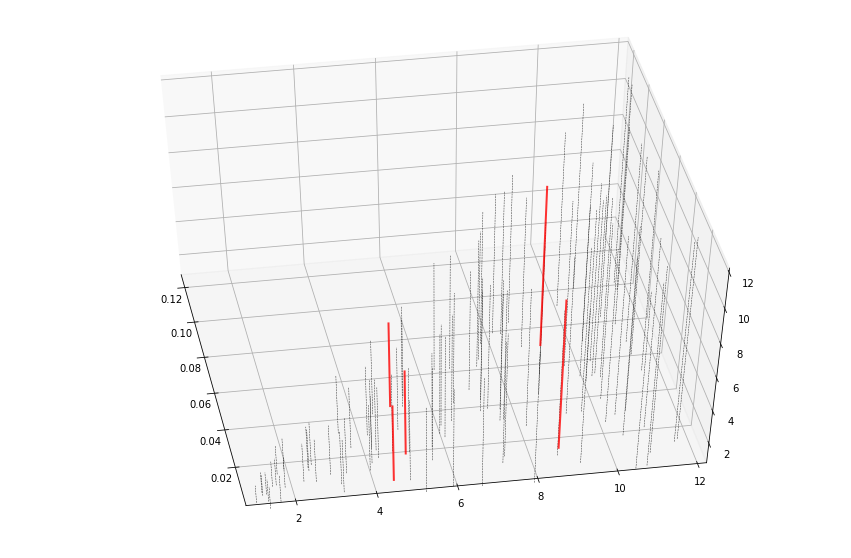

In [157]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = plt.axes(projection='3d')
ax.view_init(50, -10)

ax.set_xlim(MAX_AREA, MIN_AREA)
ax.set_ylim(MIN_LENGTH, MAX_LENGTH)
ax.set_zlim(MIN_LENGTH, MAX_LENGTH)

for i in range(bank.shape[0]):
    x = [bank.loc[i, 'Area'], bank.loc[i, 'Area']]
    y = [bank.loc[i, 'Length'], bank.loc[i, 'Length']]
    z = [0, bank.loc[i, 'Length']]
    ax.plot(x,y,z,'k--',alpha=0.8, linewidth=0.5)

for i in range(dsgn.shape[0]):
    x = [dsgn.loc[i, 'Area'], dsgn.loc[i, 'Area']]
    y = [dsgn.loc[i, 'Length'], dsgn.loc[i, 'Length']]
    z = [0, dsgn.loc[i, 'Length']]
    ax.plot(x,y,z, alpha=0.8, linewidth=2, color='red')
    


# Optimization

## 1) With brute force

Iterate through all the possibilities, and choose the best performing mapping.

In [ ]:
#TODO

## 2) With matrix

Create fitness matrix with 1's if MB element is longer than DS element.

In [ ]:
# import numpy as np
# import pandas as pd

# fit = pd.DataFrame(0, index=ND_labels, columns=MB_labels)

# for i in range(len(MB)):
#     for j in range(len(ND)):
#         if ND[j] <= MB[i]:
#             fit.iloc[j,i] = 1
            
# fit

,B0,B1,B2,B3,B4
D0,0,1,1,1,1
D1,0,0,1,1,1
D2,0,0,0,0,1
D3,0,0,0,0,0


Eliminate rows with no match:

In [ ]:
# fit.drop(fit[fit.sum(axis=1) == 0].index, inplace=True)
# fit

,B0,B1,B2,B3,B4
D0,0,1,1,1,1
D1,0,0,1,1,1
D2,0,0,0,0,1


Eliminate columns with no match:

In [ ]:
# fit.drop(fit.columns[fit.sum() == 0], axis=1, inplace=True)
# fit

,B1,B2,B3,B4
D0,1,1,1,1
D1,0,1,1,1
D2,0,0,0,1


Apply mapping if only one match in a row

In [ ]:
# MB_updated

[1, 3, 4, 5, 7]

In [ ]:
# mapping

{'D0': '', 'D1': '', 'D2': '', 'D3': ''}

In [ ]:
# if (fit.sum(axis=1) == 1).sum() > 0:
#   row_id = fit[fit.sum(axis=1) == 1].index[0]
#   col_id = fit.loc[row_id].idxmax()

#   mapping[row_id] = col_id
#   col_loc = MB_labels.index(col_id)
#   row_loc = ND_labels.index(row_id)
#   MB_updated[col_loc] = MB_updated[col_loc] - ND[row_loc]

In [ ]:
# fit.loc['D2']

B1    0
B2    0
B3    0
B4    1
Name: D2, dtype: int64

In [ ]:
# fit.drop('D2', inplace=True)

In [ ]:
# fit

,B1,B2,B3,B4
D0,1,1,1,1
D1,0,1,1,1


update length mapping

In [ ]:
# for j in range( fit.shape[0] ):
#   if ND[ND_labels.index(fit.iloc[j].name)] > MB_updated[col_loc]:
#     fit.iloc[j, col_loc] = 0
# fit

IndexError: ignored

## 3) With genetic algorithm

In [ ]:
!pip3 install pygad
import pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 4) With linear programming (OR Tolls)

## Comparison